<a href="https://colab.research.google.com/github/WEKSTER08/Song_recommender_arch-protoype/blob/main/Indian_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import librosa
import librosa.display as ld
# import librosa.display
import IPython.display as ipd
import scipy.stats as stats

In [ ]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
!ls

drive  sample_data


In [ ]:
%cd drive/MyDrive/ML_Data/imd1-Language/


/content/drive/MyDrive/ML_Data/imd1-Language


In [ ]:
!ls

bengali   gujrati  kannada    marathi  punjabi
bhojpuri  hindi    malayalam  odia     tamil


In [ ]:
# load audio files with librosa

# sr = sampling rate (default sr=22050)
classical, sr = librosa.load("./bengali/Aaj Basundhara (1)_shortened.wav")
# classical, sr = librosa.load("./gz02.mp3")

In [ ]:
# Setting some variables
FRAME_SIZE = 1024
HOP_LENGTH = 512

###Tempo and Beats

In [ ]:
# Tempo and beats

def tempo_beats(signal, sr):
  tempo, beats = librosa.beat.beat_track(y=signal, sr=sr)
  return tempo, beats.shape[0]

tempo, beats = tempo_beats(classical, sr)
print("No. of beats: ", beats)
print("Tempo (beats per minute): ", tempo)

No. of beats:  49
Tempo (beats per minute):  99.38401442307692


## Time Domain Features

###Amplitude Envelope

In [ ]:
def amplitude_envelope(signal, frame_size, hop_length):
    amplitude_envelope = []
    # calculate amplitude envelope for each frame
    for i in range(0, len(signal), hop_length): 
        amplitude_envelope_current_frame = max(signal[i:i+frame_size]) 
        amplitude_envelope.append(amplitude_envelope_current_frame)
    
    return np.array(amplitude_envelope)  

In [ ]:
# creating AE
ae_classical = amplitude_envelope(classical, FRAME_SIZE, HOP_LENGTH)
# number of frames in amplitude envelope
len(ae_classical)

1292

###Root mean sqaure energy

In [ ]:
def root_mean_square(signal, frame_size, hop_length):
  return librosa.feature.rms(y=signal,frame_length=frame_size,hop_length=hop_length)[0]

### Zero Crossing Rate

In [ ]:
def zero_crossing_rate(signal, frame_size, hop_length):
  return librosa.feature.zero_crossing_rate(y=signal,frame_length=frame_size,hop_length=hop_length)[0]

##Convertnig time domain to frequency domain

###Applying DFT

In [ ]:
def magnitude_spectrum(signal):
    X = np.fft.fft(signal) # Applying FFT to the signal
    return np.absolute(X) # Magnitude spectrum: Magnitude of each bin

In [ ]:
def plot_magnitude_spectrum(mag_spec, sr, title, f_ratio=1):
    plt.figure()
    
    f = np.linspace(0, sr, len(mag_spec))
    f_bins = int(len(mag_spec)*f_ratio) 
    f_bins = int (np.abs(f_bins/2)) 
    
    plt.plot(f[:f_bins], mag_spec[:f_bins])
    plt.xlabel('Frequency (Hz)')
    plt.title(title)

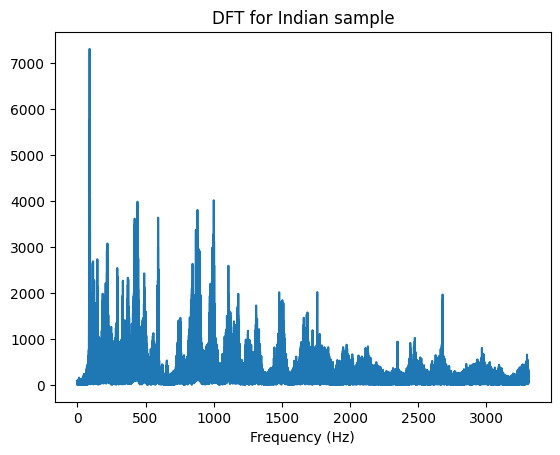

In [ ]:
ms = magnitude_spectrum(classical)
plot_magnitude_spectrum(ms, sr, "DFT for Indian sample", f_ratio=0.3)

###Extracting the short time fourier transform (STFT)

In [ ]:
def STFT(signal, frame_length, hop_size):
  return librosa.stft(signal, n_fft=frame_length, hop_length=hop_size)

In [ ]:
STFT_classical = STFT(classical, FRAME_SIZE, HOP_LENGTH)
STFT_classical.shape

(513, 1292)

###Spectrogram

In [ ]:
# Converting it from power scale to decibels so its visually percievable
def STFT_logscale(STFT):
  return librosa.power_to_db(STFT)

spectrogram_classical_logscale = STFT_logscale(STFT_classical) 

<ipython-input-20-c7e3797cc3df>:3: UserWarning: power_to_db was called on complex input so phase information will be discarded. To suppress this warning, call power_to_db(np.abs(D)**2) instead.
  return librosa.power_to_db(STFT)


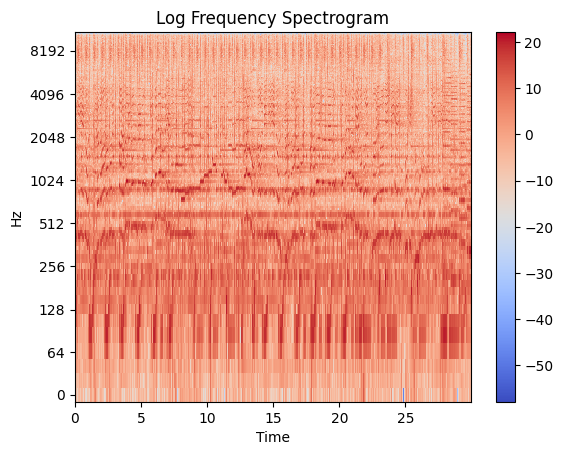

In [ ]:
def plot_spectrogram(spectogram, sr, hop_length, y_axis="linear", title='None'):
    plt.figure()
    plt.title(title)
    librosa.display.specshow(spectogram, 
                             sr=sr, 
                             hop_length=hop_length, 
                             x_axis="time", 
                             y_axis=y_axis)
    plt.colorbar()
    
plot_spectrogram(spectrogram_classical_logscale,sr,hop_length=HOP_LENGTH,y_axis="log", title="Log Frequency Spectrogram")


###Mel-spectrogram


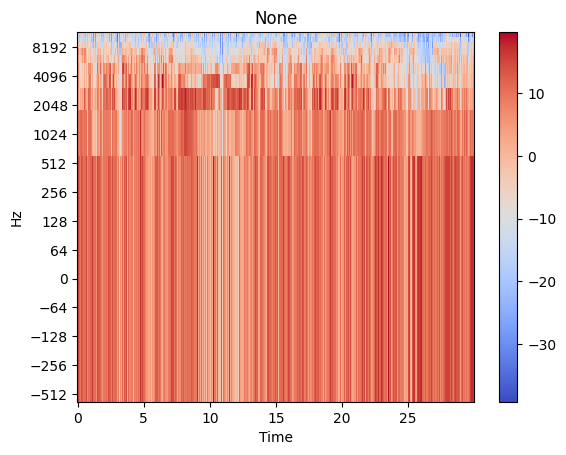

In [ ]:
def log_mel_spectrogram(signal, frame_size, hop_length):
  mel = librosa.feature.melspectrogram(y=signal, sr=sr, n_fft=frame_size,hop_length=hop_length,n_mels=10)
  return librosa.power_to_db(mel)

log_mel_spectrogram = log_mel_spectrogram(classical, FRAME_SIZE, HOP_LENGTH)

plot_spectrogram(log_mel_spectrogram,sr,hop_length=HOP_LENGTH,y_axis="log")

##MFCCs

In [ ]:
def mfcc(signal, sr, n_mfcc = 1):
  mfcc_val = librosa.feature.mfcc(y=signal, n_mfcc = n_mfcc, sr=sr)
  return mfcc_val

(1, 1292)


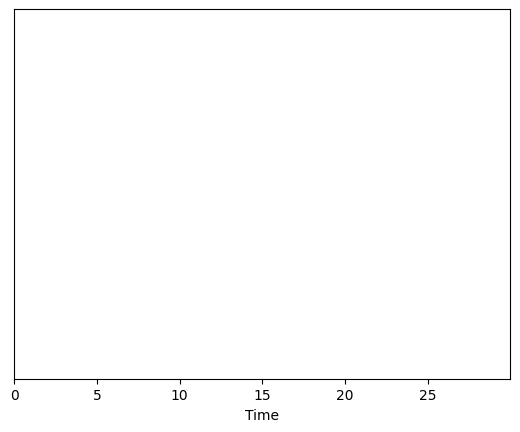

In [ ]:
mfccs = mfcc(classical, sr)
print(mfccs.shape)
# Plotting MFCCs
plt.figure()
librosa.display.specshow(mfccs, x_axis="time", sr=sr)
plt.show()


## Frequency domiain features

Band energy Ratio

In [ ]:
split_frequency = 2000
num_frequency_bins = 1025

# Finding the frequency bin associated with a given split frequency
def split_frequency_bin(sr, split_frequency = 2000, num_frequency_bins = 1025):
    frequency_range = sr / 2
    frequency_delta_per_bin = frequency_range / num_frequency_bins
    split_frequency_bin = math.floor(split_frequency / frequency_delta_per_bin)
    return int(split_frequency_bin)

In [ ]:
sfb = split_frequency_bin(split_frequency, sr, num_frequency_bins)
sfb

22601

###Spectral Centroid

In [ ]:
def spectral_centroid(signal, sr, frame_size, hop_length):
   return librosa.feature.spectral_centroid(y=signal, sr=sr, n_fft=frame_size,hop_length=hop_length)[0]

1292


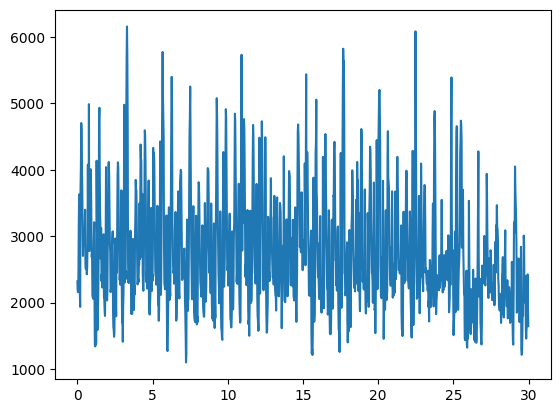

In [ ]:
sc_classical = spectral_centroid(classical, sr, frame_size=FRAME_SIZE, hop_length=HOP_LENGTH,)
sc_classical.shape

frames = range(len(sc_classical))
t = librosa.frames_to_time(frames, hop_length=HOP_LENGTH)
print(len(t))

plt.figure()
plt.plot(t, sc_classical)
plt.show()

###Spectral Bandwidth

In [ ]:
def bandwidth(signal, sr, frame_size, hop_length):
  return librosa.feature.spectral_bandwidth(y=signal, sr=sr, n_fft=frame_size,hop_length=hop_length)[0]

<function matplotlib.pyplot.show(close=None, block=None)>

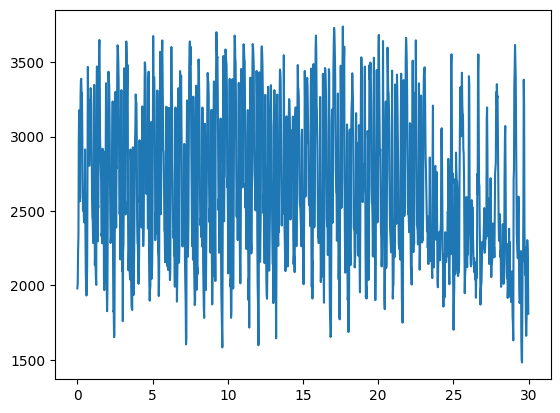

In [ ]:
bw_classical = bandwidth(classical, sr, FRAME_SIZE, HOP_LENGTH)
bw_classical.shape
plt.figure()
plt.plot(t,bw_classical)
plt.show

###Spectral Rolloff

In [ ]:
def spectral_rolloff(signal, sr, frame_size, hop_length):
   return librosa.feature.spectral_rolloff(y=signal, sr=sr, n_fft=frame_size,hop_length=hop_length)[0]

<function matplotlib.pyplot.show(close=None, block=None)>

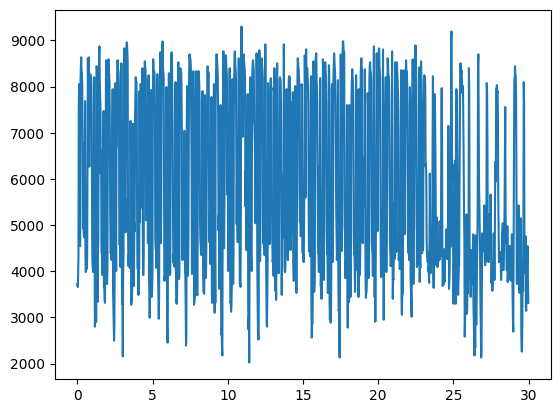

In [ ]:
sr_classical = spectral_rolloff(classical, sr, FRAME_SIZE, HOP_LENGTH)
sr_classical.shape
plt.figure()
plt.plot(t,sr_classical)
plt.show

##Calculate all values

In [ ]:
row_vals= []
def calculate_features(signal, sr, frame_size, hop_length):
  tempo, beats = tempo_beats(signal, sr)
  ae = np.mean(amplitude_envelope(signal, frame_size, hop_length))
  rms = np.mean(root_mean_square(signal, frame_size, hop_length))
  zcr = np.mean(zero_crossing_rate(signal, frame_size, hop_length))
  stft = STFT(signal, frame_size, hop_length)
  # spectrogram = spectogram(stft)
  # ber = np.mean(band_energy_ratio(spectrogram, sr, split_frequency = 2000))
  spec_cent = np.mean(spectral_centroid(signal, sr, frame_size, hop_length))
  bw = np.mean(bandwidth(signal, sr, frame_size, hop_length))
  spec_roll = np.mean(spectral_rolloff(signal, sr, frame_size, hop_length))
  mfccs = np.mean(mfcc(signal, sr))
  row_vals = [tempo, beats, ae, rms, zcr, spec_cent, bw, spec_roll, mfccs]

  return row_vals

In [ ]:
columns = ['name', 'tempo', 'beats', 'ae', 'rms', 'zcr', 'spec_cent', 'bw', 'spec_roll', 'mfcc']
df = pd.DataFrame(columns = columns)
df = pd.DataFrame(columns=df.columns)
df

,name,tempo,beats,ae,rms,zcr,spec_cent,bw,spec_roll,mfcc


In [ ]:
!ls

bengali   gujrati  kannada    marathi  punjabi
bhojpuri  hindi    malayalam  odia     tamil


In [ ]:
%cd ..

/content/drive/MyDrive/ML_Data/imd1-Language


In [ ]:
import os
folder = os.listdir('.')
print(folder)
#going into data folder
for files in folder:
    lang_file = os.listdir('./' + files)
    #going into each language files
    for l_files in lang_file:
      path =  files+"/"+l_files
      print(path)
      audio_file, sr = librosa.load(path)
      row_values = calculate_features(audio_file, sr, FRAME_SIZE, HOP_LENGTH)
      print(row_values)
      #print(file_name)
      row_values.insert(0,files) 
      print(row_values)
      df.loc[len(df)] = row_values
df.head(5)
df.to_csv('../../indian_lang_data.csv')


Streaming output truncated to the last 5000 lines.
[107.666015625, 51, 0.29354462, 0.11517162, 0.07610535990712074, 1251.4405734479087, 1071.859481475413, 2396.6355078729684, -206.67444]
['kannada', 107.666015625, 51, 0.29354462, 0.11517162, 0.07610535990712074, 1251.4405734479087, 1071.859481475413, 2396.6355078729684, -206.67444]
kannada/Lokanmudayan - Thanu Ninnadhu Jeevana (1)_shortened.wav
[161.4990234375, 79, 0.3277122, 0.12924054, 0.07552335284442724, 1194.8532867979272, 966.0353301264978, 2281.569536994485, -196.88022]
['kannada', 161.4990234375, 79, 0.3277122, 0.12924054, 0.07552335284442724, 1194.8532867979272, 966.0353301264978, 2281.569536994485, -196.88022]
kannada/Maanavaro Neevu Daanavaro (2)_shortened.wav
[135.99917763157896, 57, 0.49807394, 0.17542417, 0.12685259650735295, 1855.2327274421941, 1414.818881848274, 3487.928908971072, -114.86785]
['kannada', 135.99917763157896, 57, 0.49807394, 0.17542417, 0.12685259650735295, 1855.2327274421941, 1414.818881848274, 3487.9289

In [ ]:
df

,name,tempo,beats,ae,rms,zcr,spec_cent,bw,spec_roll,mfcc
0,malayalam,123.046875,57,0.696402,0.257700,0.103745,1945.697039,1960.275946,3784.343783,-55.566963
1,malayalam,151.999081,68,0.664262,0.263068,0.088711,2277.753056,2855.433319,5653.182483,-42.435623
2,malayalam,107.666016,54,0.442751,0.162858,0.068079,1482.346371,1669.679706,2878.215929,-152.063950
3,malayalam,112.347147,55,0.310417,0.100069,0.130954,2532.211464,2678.412169,5577.882938,-120.721649
4,malayalam,103.359375,50,0.469579,0.182269,0.079089,2095.184838,2503.409942,4599.255522,-105.181152
5,malayalam,123.046875,50,0.513953,0.220552,0.128209,1781.756001,1227.364508,3028.031690,-100.997604
6,malayalam,172.265625,85,0.257438,0.093749,0.150016,1798.754681,1180.580745,3065.081466,-216.690216
7,malayalam,198.768029,95,0.215541,0.081844,0.064690,1253.427888,1200.171973,2579.117738,-218.729294
8,malayalam,73.828125,35,0.398951,0.133832,0.139376,2891.421527,2863.152328,6170.296022,-97.389053
9,malayalam,135.999178,61,0.475232,0.196080,0.057736,1405.851506,1771.133028,2939.248893,-127.769112


In [ ]:
%cd ../../

/content/drive/MyDrive


In [ ]:
!ls


 carnatic	      indian_data_v1.gsheet   indian_lang_data_full.csv
'Colab Notebooks'     indian_data_v2.csv      indian_lang_data_full.gsheet
 indian_data.csv      indian_data_v2.gsheet   ML_Data
 indian_data_v1.csv   indian_lang_data.csv    VID-20230320-WA0009~2.mp4


In [ ]:
import requests as rs
csv_url=YOUR_CSV_DOWNLOAD_URL
res=rs.get(url=csv_url)
open('google.csv', 'wb').write(res.content)

In [ ]:
df_data = pd.read_csv('indian_lang_data_full.csv')
df_data

,Unnamed: 0,name,tempo,beats,ae,rms,zcr,spec_cent,bw,spec_roll,mfcc
0,0,malayalam,123.046875,57,0.696402,0.257700,0.103745,1945.697039,1960.275946,3784.343783,-55.566963
1,1,malayalam,151.999081,68,0.664262,0.263068,0.088711,2277.753056,2855.433319,5653.182483,-42.435623
2,2,malayalam,107.666016,54,0.442751,0.162858,0.068079,1482.346371,1669.679706,2878.215929,-152.063950
3,3,malayalam,112.347147,55,0.310417,0.100069,0.130954,2532.211464,2678.412169,5577.882938,-120.721650
4,4,malayalam,103.359375,50,0.469579,0.182269,0.079089,2095.184838,2503.409942,4599.255522,-105.181150
...,...,...,...,...,...,...,...,...,...,...,...
5509,5509,telugu,92.285156,45,0.174262,0.060266,0.107423,1941.564353,1710.827924,3602.744881,-220.491870
5510,5510,telugu,123.046875,61,0.175922,0.056918,0.145775,2174.448094,1835.518661,3818.610243,-170.266220
5511,5511,telugu,151.999081,75,0.094396,0.032541,0.102380,1966.884672,2019.361298,3763.243911,-260.020230
5512,5512,telugu,103.359375,50,0.180993,0.059907,0.118454,2229.953680,2059.592629,4103.541853,-199.959530


In [ ]:
from sklearn.decomposition import PCA
df_normalized=(df - df.mean()) / df.std()
df.dropna()
pca = PCA(n_components=df.shape[1])
pca.fit(df_normalized)

# Reformat and view results
loadings = pandas.DataFrame(pca.components_.T,
columns=['PC%s' % _ for _ in range(len(df_normalized.columns))],
index=df.columns)
print(loadings)

plot.plot(pca.explained_variance_ratio_)
plot.ylabel('Explained Variance')
plot.xlabel('Components')
plot.show()

In [ ]:

X = df_data.iloc[:,2:11].values
y = df_data.iloc[:,1].values
df_data = df_data.drop(columns=['name'])
print(X,y)



[[ 1.23046875e+02  5.70000000e+01  6.96401660e-01 ...  1.96027595e+03
   3.78434378e+03 -5.55669630e+01]
 [ 1.51999081e+02  6.80000000e+01  6.64261800e-01 ...  2.85543332e+03
   5.65318248e+03 -4.24356230e+01]
 [ 1.07666016e+02  5.40000000e+01  4.42751350e-01 ...  1.66967971e+03
   2.87821593e+03 -1.52063950e+02]
 ...
 [ 1.51999081e+02  7.50000000e+01  9.43961500e-02 ...  2.01936130e+03
   3.76324391e+03 -2.60020230e+02]
 [ 1.03359375e+02  5.00000000e+01  1.80993330e-01 ...  2.05959263e+03
   4.10354185e+03 -1.99959530e+02]
 [ 1.51999081e+02  7.40000000e+01  5.35785600e-01 ...  2.22623353e+03
   4.49373949e+03 -7.93558040e+01]] ['malayalam' 'malayalam' 'malayalam' ... 'telugu' 'telugu' 'telugu']


In [ ]:
print(X)

[[ 1.23046875e+02  5.70000000e+01  6.96401660e-01 ...  1.96027595e+03
   3.78434378e+03 -5.55669630e+01]
 [ 1.51999081e+02  6.80000000e+01  6.64261800e-01 ...  2.85543332e+03
   5.65318248e+03 -4.24356230e+01]
 [ 1.07666016e+02  5.40000000e+01  4.42751350e-01 ...  1.66967971e+03
   2.87821593e+03 -1.52063950e+02]
 ...
 [ 1.12347147e+02  5.40000000e+01  4.23834920e-01 ...  2.36260170e+03
   4.52103933e+03 -7.47680000e+01]
 [ 1.61499023e+02  6.50000000e+01  3.41200400e-01 ...  2.48494962e+03
   4.15164156e+03 -1.34066640e+02]
 [ 7.83025568e+01  3.80000000e+01  3.45906800e-01 ...  2.41978011e+03
   3.86199331e+03 -1.45768100e+02]]


In [ ]:
from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(X)

print(np.std(X_std))

1.0


Covariance matrix first 5 rows and columns:
 [[ 1.00019956  0.97639785 -0.04053939 -0.0345508  -0.06012041]
 [ 0.97639785  1.00019956 -0.01157059 -0.01089264 -0.03292116]
 [-0.04053939 -0.01157059  1.00019956  0.97376406  0.07672251]
 [-0.0345508  -0.01089264  0.97376406  1.00019956 -0.02608731]
 [-0.06012041 -0.03292116  0.07672251 -0.02608731  1.00019956]]
[4.40998794 1.98007793 1.81664326 0.59856855 0.12120969 0.00646069
 0.02890488 0.01765352 0.02228959]
Top 5 Eigenvalues in descending order:
4.409987936616636
1.980077931756363
1.8166432575052636
0.5985685466081516
0.12120969374993429
0.028904884909579574
0.022289589836135208
0.017653521002837597
0.006460686707975178


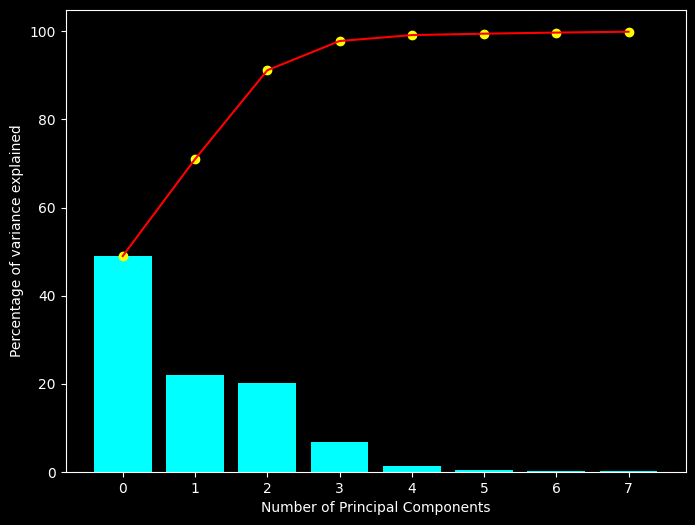

In [ ]:
#finding the covariance 
cov_mat = np.cov(X_std.T)

print('Covariance matrix first 5 rows and columns:\n', cov_mat[0:5, 0:5])

#finding eigen values
eig_vals, eig_vecs = np.linalg.eig(cov_mat)
print(eig_vals)

eig_pairs = []
eigen_value_pairs ={}

# for i in range(len(eig_vals)):
#   eigen_value_pairs[i] = (np.abs(eig_vals[i]), eig_vecs[:,i])
# col_nums = sorted(eigen_value_pairs.items(), key=lambda x:x[1])
# print(col_nums)

for i in range(len(eig_vals)):
  eig_pairs.append( (np.abs(eig_vals[i]), eig_vecs[:,i]) )
# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort(key=lambda x: x[0], reverse=True)
print('Top 5 Eigenvalues in descending order:')
for i in eig_pairs[:10]:
    print(i[0])

total = np.sum(eig_vals)
eig_val = 100 * eig_vals/total
eig_val = sorted(eig_val, reverse=True)

with plt.style.context('dark_background'):
  plt.figure(figsize = (8, 6))
  plt.xlabel("Number of Principal Components")
  plt.ylabel("Percentage of variance explained")
  plt.bar(range(8), eig_val[:8], color = "aqua")
  plt.plot(range(8), np.cumsum(eig_val[:8]), color = "red")
  plt.scatter(range(8), np.cumsum(eig_val[:8]), color = "yellow")


In [ ]:
from sklearn.decomposition import PCA

model = PCA(n_components=3).fit(X_std)
X_pc = model.transform(X_std)

# number of components
n_pcs= model.components_.shape[0]

# get the index of the most important feature on EACH component i.e. largest absolute value
# using LIST COMPREHENSION HERE
most_important = [np.abs(model.components_[i]).argmax() for i in range(n_pcs)]

initial_feature_names = ['tempo', 'beats', 'ae', 'rms', 'zcr', 'spec_cent', 'bw', 'spec_roll', 'mfcc']

# get the names
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

# using LIST COMPREHENSION HERE AGAIN
dic = {'PC{}'.format(i+1): most_important_names[i] for i in range(n_pcs)}

# build the dataframe
imp_features = pd.DataFrame(sorted(dic.items()))
imp_features

,0,1
0,PC1,spec_roll
1,PC2,beats
2,PC3,rms


In [ ]:
pca_df = df_data[['zcr','ae','name']].copy()

In [ ]:
pca_df

,zcr,ae,name
0,0.103745,0.696402,malayalam
1,0.088711,0.664262,malayalam
2,0.068079,0.442751,malayalam
3,0.130954,0.310417,malayalam
4,0.079089,0.469579,malayalam
...,...,...,...
5509,0.107423,0.174262,telugu
5510,0.145775,0.175922,telugu
5511,0.102380,0.094396,telugu
5512,0.118454,0.180993,telugu


In [ ]:

# Always normalise your data before feeding it to an algorithm
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plot

X_std = StandardScaler().fit_transform(X)

pca = PCA(n_components=4)
pca.fit(X_std)

plot.plot(pca.explained_variance_ratio_)
plot.ylabel('Explained Variance')
plot.xlabel('Components')
plot.show()


# print(np.std(X_std))

# #finding the covariance 
# cov_mat = np.cov(X_std.T)

# print('Covariance matrix first 5 rows and columns:\n', cov_mat[0:5, 0:5])

# #finding eigen values
# eig_vals, eig_vecs = np.linalg.eig(cov_mat)



/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

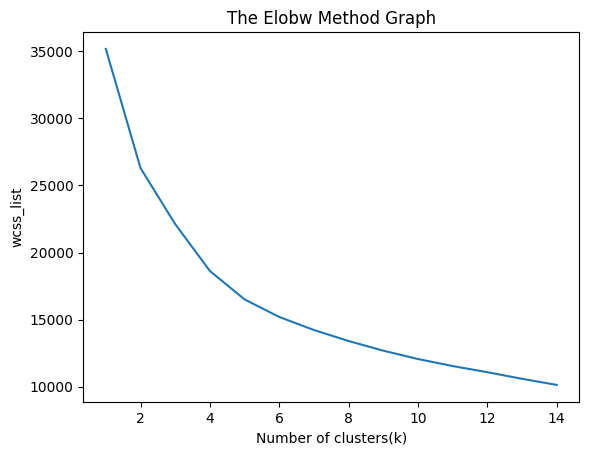

In [ ]:
from sklearn.cluster import KMeans
wcss_list = []
for i in range(1, 15):  
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state= 42)  
    kmeans.fit(X_std)  
    wcss_list.append(kmeans.inertia_)  
plt.plot(range(1, 15), wcss_list)  
plt.title('The Elobw Method Graph')  
plt.xlabel('Number of clusters(k)')  
plt.ylabel('wcss_list')  
plt.show()  


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


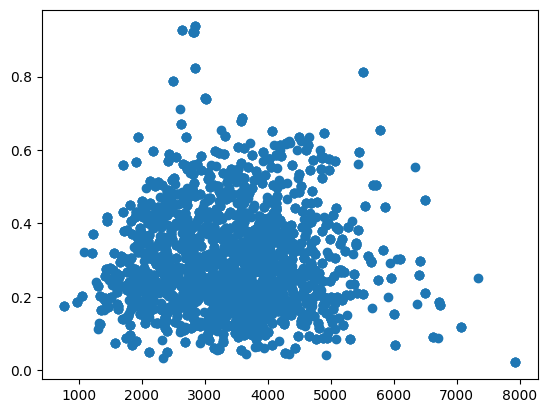

In [ ]:
kmeans = KMeans(n_clusters=5, init='k-means++', random_state= 42)  
cluster = kmeans.fit(X_std) 
plt.scatter(x=df_data['spec_roll'],y=df_data['ae'])

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn import metrics

def dbscan(X_std,eps,min_samples):
  db = DBSCAN(eps=eps, min_samples=min_samples).fit(X_std)
  core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
  core_samples_mask[db.core_sample_indices_] = True
  labels = db.labels_

  # Number of clusters in labels, ignoring noise if present.
  n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
  n_noise_ = list(labels).count(-1)

  print("Estimated number of clusters: %d" % n_clusters_)
  print("Estimated number of noise points: %d" % n_noise_)
  print("Homogeneity: %0.3f" % metrics.homogeneity_score(y, labels))
  print("Completeness: %0.3f" % metrics.completeness_score(y, labels))
  print("V-measure: %0.3f" % metrics.v_measure_score(y, labels))
  print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(y, labels))
  print(
      "Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(y, labels)
  )
  n_clusters_, n_noise, h_score, v_measure = n_clusters_, n_noise_, metrics.homogeneity_score(y, labels), metrics.v_measure_score(y, labels)
  return n_clusters_, n_noise, h_score, v_measure

In [ ]:
from sklearn.manifold import TSNE


music_proj = TSNE(n_components=2,perplexity=27,n_iter=1000,random_state=22132).fit_transform(X_std)
music_proj

array([[ -1.8990586,  -3.484931 ],
       [-14.03876  , -50.405724 ],
       [ 38.19312  ,   3.3323286],
       ...,
       [  6.356189 ,  32.410072 ],
       [ 27.381836 , -34.936504 ],
       [ 29.837965 ,  25.540022 ]], dtype=float32)

##Unlabeled Data

In [ ]:
import plotly.graph_objects as go
import plotly.express as px

print(len(music_proj))
dicti = {"Comp1":[],"Comp2":[]}
for row in music_proj:
    
    
    
    dicti["Comp1"].append(row[0])
    dicti["Comp2"].append(row[1])

# print(dicti)

final_df = pd.DataFrame.from_dict(dicti)
print (final_df)

for_x = final_df.Comp1.tolist()
for_y = final_df.Comp2.tolist()

fig = px.scatter(x=for_x, y=for_y,title="TSNE_plot")
fig.show(renderer = "colab")

4397
          Comp1      Comp2
0     55.632721 -31.084368
1     42.557922   8.873981
2     -8.521963 -58.690742
3     12.787402 -52.038177
4     27.710409  34.536476
...         ...        ...
4392  15.569728 -33.995651
4393  15.733678 -35.583927
4394 -18.443497 -32.335606
4395 -27.447906  -9.090344
4396  39.617882 -26.451128

[4397 rows x 2 columns]


In [ ]:
X_final = final_df.iloc[:,:2].values
X_final
X_f_std = StandardScaler().fit_transform(X_final)

dbscan(X_std,1.7395134064803408,3)

Estimated number of clusters: 6
Estimated number of noise points: 9
Homogeneity: 0.008
Completeness: 1.000
V-measure: 0.015
Adjusted Rand Index: 0.000
Adjusted Mutual Information: -0.000


(6, 9, 0.007524555372267971, 0.014936718578511947)

In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 6.1 MB/s eta 0:00:00


In [ ]:
import optuna
def objective(trial):
  eps = trial.suggest_float('eps',1,3)
  min_samples = trial.suggest_int('min_samples',3,10)
  n_clusters_, n_noise, h_score, v_measure = dbscan(X_std,eps=eps,min_samples=min_samples)
  if h_score !=0 :  obj_score = 5*n_noise + 5*n_clusters_ + 1000*v_measure
  return obj_score
study = optuna.create_study()
study.optimize(objective,n_trials=80)
print("The best parameters = ",study.best_params,". Time taken is= ", time_taken,'\n')



[I 2023-05-06 01:19:30,427] A new study created in memory with name: no-name-8440c6c8-54eb-4a61-8277-f2769298482e


Estimated number of clusters: 1
Estimated number of noise points: 11
Homogeneity: 0.000
Completeness: 0.064
V-measure: 0.001
Adjusted Rand Index: -0.000
Adjusted Mutual Information: -0.000


[I 2023-05-06 01:19:33,857] Trial 0 finished with value: 60.862021215363804 and parameters: {'eps': 1.8402050104252377, 'min_samples': 6}. Best is trial 0 with value: 60.862021215363804.
[I 2023-05-06 01:19:36,855] Trial 1 finished with value: 30.59697704722008 and parameters: {'eps': 2.4411177094427634, 'min_samples': 6}. Best is trial 1 with value: 30.59697704722008.


Estimated number of clusters: 1
Estimated number of noise points: 5
Homogeneity: 0.000
Completeness: 0.087
V-measure: 0.001
Adjusted Rand Index: -0.000
Adjusted Mutual Information: -0.000


[I 2023-05-06 01:19:37,670] Trial 2 finished with value: 302.20984831199047 and parameters: {'eps': 1.2166400862857496, 'min_samples': 4}. Best is trial 1 with value: 30.59697704722008.


Estimated number of clusters: 2
Estimated number of noise points: 58
Homogeneity: 0.001
Completeness: 0.037
V-measure: 0.002
Adjusted Rand Index: 0.000
Adjusted Mutual Information: 0.001


[I 2023-05-06 01:19:39,779] Trial 3 finished with value: 30.59697704722008 and parameters: {'eps': 2.3983646613802403, 'min_samples': 9}. Best is trial 1 with value: 30.59697704722008.


Estimated number of clusters: 1
Estimated number of noise points: 5
Homogeneity: 0.000
Completeness: 0.087
V-measure: 0.001
Adjusted Rand Index: -0.000
Adjusted Mutual Information: -0.000


[I 2023-05-06 01:19:41,101] Trial 4 finished with value: 60.862021215363804 and parameters: {'eps': 1.8205795702843635, 'min_samples': 4}. Best is trial 1 with value: 30.59697704722008.


Estimated number of clusters: 1
Estimated number of noise points: 11
Homogeneity: 0.000
Completeness: 0.064
V-measure: 0.001
Adjusted Rand Index: -0.000
Adjusted Mutual Information: -0.000


[I 2023-05-06 01:19:42,051] Trial 5 finished with value: 1045.242575920722 and parameters: {'eps': 1.0903675454413824, 'min_samples': 10}. Best is trial 1 with value: 30.59697704722008.


Estimated number of clusters: 2
Estimated number of noise points: 206
Homogeneity: 0.003
Completeness: 0.035
V-measure: 0.005
Adjusted Rand Index: 0.000
Adjusted Mutual Information: 0.004
Estimated number of clusters: 1
Estimated number of noise points: 2
Homogeneity: 0.000
Completeness: 0.183
V-measure: 0.001
Adjusted Rand Index: 0.000
Adjusted Mutual Information: -0.000


[I 2023-05-06 01:19:44,912] Trial 6 finished with value: 15.558098260920596 and parameters: {'eps': 2.956180556708837, 'min_samples': 3}. Best is trial 6 with value: 15.558098260920596.
[I 2023-05-06 01:19:45,910] Trial 7 finished with value: 126.47672220579338 and parameters: {'eps': 1.4589494942624213, 'min_samples': 4}. Best is trial 6 with value: 15.558098260920596.


Estimated number of clusters: 1
Estimated number of noise points: 24
Homogeneity: 0.001
Completeness: 0.057
V-measure: 0.001
Adjusted Rand Index: 0.000
Adjusted Mutual Information: 0.001
Estimated number of clusters: 1
Estimated number of noise points: 6
Homogeneity: 0.000
Completeness: 0.095
V-measure: 0.001
Adjusted Rand Index: -0.000
Adjusted Mutual Information: -0.000


[I 2023-05-06 01:19:49,199] Trial 8 finished with value: 35.763372506558085 and parameters: {'eps': 2.1465039709200013, 'min_samples': 5}. Best is trial 6 with value: 15.558098260920596.


Estimated number of clusters: 1
Estimated number of noise points: 5
Homogeneity: 0.000
Completeness: 0.087
V-measure: 0.001
Adjusted Rand Index: -0.000


[I 2023-05-06 01:19:52,409] Trial 9 finished with value: 30.59697704722008 and parameters: {'eps': 2.5504571973675008, 'min_samples': 8}. Best is trial 6 with value: 15.558098260920596.


Adjusted Mutual Information: -0.000


[I 2023-05-06 01:19:55,107] Trial 10 finished with value: 15.558098260920596 and parameters: {'eps': 2.9721179087327574, 'min_samples': 3}. Best is trial 6 with value: 15.558098260920596.


Estimated number of clusters: 1
Estimated number of noise points: 2
Homogeneity: 0.000
Completeness: 0.183
V-measure: 0.001
Adjusted Rand Index: 0.000
Adjusted Mutual Information: -0.000
Estimated number of clusters: 1
Estimated number of noise points: 2
Homogeneity: 0.000
Completeness: 0.183
V-measure: 0.001
Adjusted Rand Index: 0.000
Adjusted Mutual Information: -0.000


[I 2023-05-06 01:19:57,766] Trial 11 finished with value: 15.558098260920596 and parameters: {'eps': 2.933406593097308, 'min_samples': 3}. Best is trial 6 with value: 15.558098260920596.
[I 2023-05-06 01:20:00,384] Trial 12 finished with value: 15.558098260920596 and parameters: {'eps': 2.946462590394957, 'min_samples': 3}. Best is trial 6 with value: 15.558098260920596.


Estimated number of clusters: 1
Estimated number of noise points: 2
Homogeneity: 0.000
Completeness: 0.183
V-measure: 0.001
Adjusted Rand Index: 0.000
Adjusted Mutual Information: -0.000
Estimated number of clusters: 1
Estimated number of noise points: 5
Homogeneity: 0.000
Completeness: 0.087
V-measure: 0.001
Adjusted Rand Index: -0.000
Adjusted Mutual Information: -0.000


[I 2023-05-06 01:20:04,732] Trial 13 finished with value: 30.59697704722008 and parameters: {'eps': 2.7544717876703073, 'min_samples': 7}. Best is trial 6 with value: 15.558098260920596.
[I 2023-05-06 01:20:07,710] Trial 14 finished with value: 15.558098260920596 and parameters: {'eps': 2.9641328074474194, 'min_samples': 3}. Best is trial 6 with value: 15.558098260920596.


Estimated number of clusters: 1
Estimated number of noise points: 2
Homogeneity: 0.000
Completeness: 0.183
V-measure: 0.001
Adjusted Rand Index: 0.000
Adjusted Mutual Information: -0.000


[I 2023-05-06 01:20:09,193] Trial 15 finished with value: 30.59697704722008 and parameters: {'eps': 2.6368954241311306, 'min_samples': 5}. Best is trial 6 with value: 15.558098260920596.


Estimated number of clusters: 1
Estimated number of noise points: 5
Homogeneity: 0.000
Completeness: 0.087
V-measure: 0.001
Adjusted Rand Index: -0.000
Adjusted Mutual Information: -0.000


[I 2023-05-06 01:20:10,263] Trial 16 finished with value: 30.59697704722008 and parameters: {'eps': 2.710408960021434, 'min_samples': 5}. Best is trial 6 with value: 15.558098260920596.


Estimated number of clusters: 1
Estimated number of noise points: 5
Homogeneity: 0.000
Completeness: 0.087
V-measure: 0.001
Adjusted Rand Index: -0.000
Adjusted Mutual Information: -0.000


[I 2023-05-06 01:20:11,152] Trial 17 finished with value: 30.59697704722008 and parameters: {'eps': 2.2976802271296473, 'min_samples': 3}. Best is trial 6 with value: 15.558098260920596.


Estimated number of clusters: 1
Estimated number of noise points: 5
Homogeneity: 0.000
Completeness: 0.087
V-measure: 0.001
Adjusted Rand Index: -0.000
Adjusted Mutual Information: -0.000


[I 2023-05-06 01:20:12,211] Trial 18 finished with value: 30.59697704722008 and parameters: {'eps': 2.7215784680432566, 'min_samples': 7}. Best is trial 6 with value: 15.558098260920596.


Estimated number of clusters: 1
Estimated number of noise points: 5
Homogeneity: 0.000
Completeness: 0.087
V-measure: 0.001
Adjusted Rand Index: -0.000
Adjusted Mutual Information: -0.000


[I 2023-05-06 01:20:13,121] Trial 19 finished with value: 35.763372506558085 and parameters: {'eps': 2.2466783541078255, 'min_samples': 4}. Best is trial 6 with value: 15.558098260920596.


Estimated number of clusters: 1
Estimated number of noise points: 6
Homogeneity: 0.000
Completeness: 0.095
V-measure: 0.001
Adjusted Rand Index: -0.000
Adjusted Mutual Information: -0.000


[I 2023-05-06 01:20:14,103] Trial 20 finished with value: 30.59697704722008 and parameters: {'eps': 2.526994288268341, 'min_samples': 5}. Best is trial 6 with value: 15.558098260920596.


Estimated number of clusters: 1
Estimated number of noise points: 5
Homogeneity: 0.000
Completeness: 0.087
V-measure: 0.001
Adjusted Rand Index: -0.000
Adjusted Mutual Information: -0.000


[I 2023-05-06 01:20:15,257] Trial 21 finished with value: 15.558098260920596 and parameters: {'eps': 2.9925525925701066, 'min_samples': 3}. Best is trial 6 with value: 15.558098260920596.


Estimated number of clusters: 1
Estimated number of noise points: 2
Homogeneity: 0.000
Completeness: 0.183
V-measure: 0.001
Adjusted Rand Index: 0.000
Adjusted Mutual Information: -0.000


[I 2023-05-06 01:20:16,485] Trial 22 finished with value: 30.59697704722008 and parameters: {'eps': 2.833839603116032, 'min_samples': 3}. Best is trial 6 with value: 15.558098260920596.


Estimated number of clusters: 1
Estimated number of noise points: 5
Homogeneity: 0.000
Completeness: 0.087
V-measure: 0.001
Adjusted Rand Index: -0.000
Adjusted Mutual Information: -0.000


[I 2023-05-06 01:20:18,238] Trial 23 finished with value: 30.59697704722008 and parameters: {'eps': 2.860815387375646, 'min_samples': 4}. Best is trial 6 with value: 15.558098260920596.


Estimated number of clusters: 1
Estimated number of noise points: 5
Homogeneity: 0.000
Completeness: 0.087
V-measure: 0.001
Adjusted Rand Index: -0.000
Adjusted Mutual Information: -0.000


[I 2023-05-06 01:20:19,976] Trial 24 finished with value: 15.558098260920596 and parameters: {'eps': 2.998627425929707, 'min_samples': 3}. Best is trial 6 with value: 15.558098260920596.


Estimated number of clusters: 1
Estimated number of noise points: 2
Homogeneity: 0.000
Completeness: 0.183
V-measure: 0.001
Adjusted Rand Index: 0.000
Adjusted Mutual Information: -0.000


[I 2023-05-06 01:20:21,472] Trial 25 finished with value: 30.59697704722008 and parameters: {'eps': 2.8037924762674864, 'min_samples': 4}. Best is trial 6 with value: 15.558098260920596.


Estimated number of clusters: 1
Estimated number of noise points: 5
Homogeneity: 0.000
Completeness: 0.087
V-measure: 0.001
Adjusted Rand Index: -0.000
Adjusted Mutual Information: -0.000


[I 2023-05-06 01:20:22,492] Trial 26 finished with value: 30.59697704722008 and parameters: {'eps': 2.5926685896973796, 'min_samples': 3}. Best is trial 6 with value: 15.558098260920596.


Estimated number of clusters: 1
Estimated number of noise points: 5
Homogeneity: 0.000
Completeness: 0.087
V-measure: 0.001
Adjusted Rand Index: -0.000
Adjusted Mutual Information: -0.000


[I 2023-05-06 01:20:23,579] Trial 27 finished with value: 30.59697704722008 and parameters: {'eps': 2.826685394213629, 'min_samples': 6}. Best is trial 6 with value: 15.558098260920596.


Estimated number of clusters: 1
Estimated number of noise points: 5
Homogeneity: 0.000
Completeness: 0.087
V-measure: 0.001
Adjusted Rand Index: -0.000
Adjusted Mutual Information: -0.000


[I 2023-05-06 01:20:24,621] Trial 28 finished with value: 30.59697704722008 and parameters: {'eps': 2.6580572406641547, 'min_samples': 5}. Best is trial 6 with value: 15.558098260920596.


Estimated number of clusters: 1
Estimated number of noise points: 5
Homogeneity: 0.000
Completeness: 0.087
V-measure: 0.001
Adjusted Rand Index: -0.000
Adjusted Mutual Information: -0.000


[I 2023-05-06 01:20:25,725] Trial 29 finished with value: 30.59697704722008 and parameters: {'eps': 2.8468965430608764, 'min_samples': 6}. Best is trial 6 with value: 15.558098260920596.


Estimated number of clusters: 1
Estimated number of noise points: 5
Homogeneity: 0.000
Completeness: 0.087
V-measure: 0.001
Adjusted Rand Index: -0.000
Adjusted Mutual Information: -0.000


[I 2023-05-06 01:20:26,692] Trial 30 finished with value: 30.59697704722008 and parameters: {'eps': 2.4870688788972606, 'min_samples': 4}. Best is trial 6 with value: 15.558098260920596.


Estimated number of clusters: 1
Estimated number of noise points: 5
Homogeneity: 0.000
Completeness: 0.087
V-measure: 0.001
Adjusted Rand Index: -0.000
Adjusted Mutual Information: -0.000


[I 2023-05-06 01:20:27,854] Trial 31 finished with value: 15.558098260920596 and parameters: {'eps': 2.914705685802865, 'min_samples': 3}. Best is trial 6 with value: 15.558098260920596.


Estimated number of clusters: 1
Estimated number of noise points: 2
Homogeneity: 0.000
Completeness: 0.183
V-measure: 0.001
Adjusted Rand Index: 0.000
Adjusted Mutual Information: -0.000


[I 2023-05-06 01:20:29,031] Trial 32 finished with value: 15.558098260920596 and parameters: {'eps': 2.9984953681501443, 'min_samples': 3}. Best is trial 6 with value: 15.558098260920596.


Estimated number of clusters: 1
Estimated number of noise points: 2
Homogeneity: 0.000
Completeness: 0.183
V-measure: 0.001
Adjusted Rand Index: 0.000
Adjusted Mutual Information: -0.000


[I 2023-05-06 01:20:30,109] Trial 33 finished with value: 30.59697704722008 and parameters: {'eps': 2.712543102824408, 'min_samples': 4}. Best is trial 6 with value: 15.558098260920596.


Estimated number of clusters: 1
Estimated number of noise points: 5
Homogeneity: 0.000
Completeness: 0.087
V-measure: 0.001
Adjusted Rand Index: -0.000
Adjusted Mutual Information: -0.000


[I 2023-05-06 01:20:31,281] Trial 34 finished with value: 20.626199344625483 and parameters: {'eps': 2.901045412564074, 'min_samples': 3}. Best is trial 6 with value: 15.558098260920596.


Estimated number of clusters: 1
Estimated number of noise points: 3
Homogeneity: 0.000
Completeness: 0.143
V-measure: 0.001
Adjusted Rand Index: 0.000
Adjusted Mutual Information: -0.000


[I 2023-05-06 01:20:32,778] Trial 35 finished with value: 30.59697704722008 and parameters: {'eps': 2.4274793294069514, 'min_samples': 4}. Best is trial 6 with value: 15.558098260920596.


Estimated number of clusters: 1
Estimated number of noise points: 5
Homogeneity: 0.000
Completeness: 0.087
V-measure: 0.001
Adjusted Rand Index: -0.000
Adjusted Mutual Information: -0.000


[I 2023-05-06 01:20:34,335] Trial 36 finished with value: 30.59697704722008 and parameters: {'eps': 2.613723851157273, 'min_samples': 10}. Best is trial 6 with value: 15.558098260920596.


Estimated number of clusters: 1
Estimated number of noise points: 5
Homogeneity: 0.000
Completeness: 0.087
V-measure: 0.001
Adjusted Rand Index: -0.000
Adjusted Mutual Information: -0.000


[I 2023-05-06 01:20:36,040] Trial 37 finished with value: 30.59697704722008 and parameters: {'eps': 2.7960555747063944, 'min_samples': 3}. Best is trial 6 with value: 15.558098260920596.


Estimated number of clusters: 1
Estimated number of noise points: 5
Homogeneity: 0.000
Completeness: 0.087
V-measure: 0.001
Adjusted Rand Index: -0.000
Adjusted Mutual Information: -0.000


[I 2023-05-06 01:20:37,243] Trial 38 finished with value: 20.62209409972497 and parameters: {'eps': 2.92865090428435, 'min_samples': 4}. Best is trial 6 with value: 15.558098260920596.


Estimated number of clusters: 1
Estimated number of noise points: 3
Homogeneity: 0.000
Completeness: 0.142
V-measure: 0.001
Adjusted Rand Index: -0.000
Adjusted Mutual Information: -0.000


[I 2023-05-06 01:20:38,336] Trial 39 finished with value: 30.59697704722008 and parameters: {'eps': 2.7420897640418707, 'min_samples': 8}. Best is trial 6 with value: 15.558098260920596.


Estimated number of clusters: 1
Estimated number of noise points: 5
Homogeneity: 0.000
Completeness: 0.087
V-measure: 0.001
Adjusted Rand Index: -0.000
Adjusted Mutual Information: -0.000


[I 2023-05-06 01:20:39,052] Trial 40 finished with value: 55.713254143080846 and parameters: {'eps': 1.8980394777672176, 'min_samples': 5}. Best is trial 6 with value: 15.558098260920596.


Estimated number of clusters: 1
Estimated number of noise points: 10
Homogeneity: 0.000
Completeness: 0.057
V-measure: 0.001
Adjusted Rand Index: -0.000
Adjusted Mutual Information: -0.000


[I 2023-05-06 01:20:40,159] Trial 41 finished with value: 30.59697704722008 and parameters: {'eps': 2.8923763338316997, 'min_samples': 3}. Best is trial 6 with value: 15.558098260920596.


Estimated number of clusters: 1
Estimated number of noise points: 5
Homogeneity: 0.000
Completeness: 0.087
V-measure: 0.001
Adjusted Rand Index: -0.000
Adjusted Mutual Information: -0.000


[I 2023-05-06 01:20:41,283] Trial 42 finished with value: 15.558098260920596 and parameters: {'eps': 2.9964530086506467, 'min_samples': 3}. Best is trial 6 with value: 15.558098260920596.


Estimated number of clusters: 1
Estimated number of noise points: 2
Homogeneity: 0.000
Completeness: 0.183
V-measure: 0.001
Adjusted Rand Index: 0.000
Adjusted Mutual Information: -0.000


[I 2023-05-06 01:20:42,304] Trial 43 finished with value: 30.59697704722008 and parameters: {'eps': 2.641170754275821, 'min_samples': 4}. Best is trial 6 with value: 15.558098260920596.


Estimated number of clusters: 1
Estimated number of noise points: 5
Homogeneity: 0.000
Completeness: 0.087
V-measure: 0.001
Adjusted Rand Index: -0.000
Adjusted Mutual Information: -0.000


[I 2023-05-06 01:20:43,373] Trial 44 finished with value: 30.59697704722008 and parameters: {'eps': 2.747317055094794, 'min_samples': 3}. Best is trial 6 with value: 15.558098260920596.


Estimated number of clusters: 1
Estimated number of noise points: 5
Homogeneity: 0.000
Completeness: 0.087
V-measure: 0.001
Adjusted Rand Index: -0.000
Adjusted Mutual Information: -0.000


[I 2023-05-06 01:20:44,470] Trial 45 finished with value: 20.62209409972497 and parameters: {'eps': 2.9067151469656705, 'min_samples': 4}. Best is trial 6 with value: 15.558098260920596.


Estimated number of clusters: 1
Estimated number of noise points: 3
Homogeneity: 0.000
Completeness: 0.142
V-measure: 0.001
Adjusted Rand Index: -0.000
Adjusted Mutual Information: -0.000


[I 2023-05-06 01:20:45,460] Trial 46 finished with value: 30.59697704722008 and parameters: {'eps': 2.5327279953395037, 'min_samples': 3}. Best is trial 6 with value: 15.558098260920596.


Estimated number of clusters: 1
Estimated number of noise points: 5
Homogeneity: 0.000
Completeness: 0.087
V-measure: 0.001
Adjusted Rand Index: -0.000
Adjusted Mutual Information: -0.000


[I 2023-05-06 01:20:46,737] Trial 47 finished with value: 30.59697704722008 and parameters: {'eps': 2.7795826601142695, 'min_samples': 8}. Best is trial 6 with value: 15.558098260920596.


Estimated number of clusters: 1
Estimated number of noise points: 5
Homogeneity: 0.000
Completeness: 0.087
V-measure: 0.001
Adjusted Rand Index: -0.000
Adjusted Mutual Information: -0.000


[I 2023-05-06 01:20:48,134] Trial 48 finished with value: 30.59697704722008 and parameters: {'eps': 2.3545238415088976, 'min_samples': 9}. Best is trial 6 with value: 15.558098260920596.


Estimated number of clusters: 1
Estimated number of noise points: 5
Homogeneity: 0.000
Completeness: 0.087
V-measure: 0.001
Adjusted Rand Index: -0.000
Adjusted Mutual Information: -0.000


[I 2023-05-06 01:20:49,707] Trial 49 finished with value: 30.59697704722008 and parameters: {'eps': 2.7024747975693435, 'min_samples': 5}. Best is trial 6 with value: 15.558098260920596.


Estimated number of clusters: 1
Estimated number of noise points: 5
Homogeneity: 0.000
Completeness: 0.087
V-measure: 0.001
Adjusted Rand Index: -0.000
Adjusted Mutual Information: -0.000


[I 2023-05-06 01:20:51,285] Trial 50 finished with value: 15.558098260920596 and parameters: {'eps': 2.933362708095976, 'min_samples': 3}. Best is trial 6 with value: 15.558098260920596.


Estimated number of clusters: 1
Estimated number of noise points: 2
Homogeneity: 0.000
Completeness: 0.183
V-measure: 0.001
Adjusted Rand Index: 0.000
Adjusted Mutual Information: -0.000


[I 2023-05-06 01:20:52,370] Trial 51 finished with value: 15.558098260920596 and parameters: {'eps': 2.985991687621949, 'min_samples': 3}. Best is trial 6 with value: 15.558098260920596.


Estimated number of clusters: 1
Estimated number of noise points: 2
Homogeneity: 0.000
Completeness: 0.183
V-measure: 0.001
Adjusted Rand Index: 0.000
Adjusted Mutual Information: -0.000


[I 2023-05-06 01:20:53,428] Trial 52 finished with value: 30.59697704722008 and parameters: {'eps': 2.8461606562966812, 'min_samples': 3}. Best is trial 6 with value: 15.558098260920596.


Estimated number of clusters: 1
Estimated number of noise points: 5
Homogeneity: 0.000
Completeness: 0.087
V-measure: 0.001
Adjusted Rand Index: -0.000
Adjusted Mutual Information: -0.000


[I 2023-05-06 01:20:54,511] Trial 53 finished with value: 20.62209409972497 and parameters: {'eps': 2.934188786372677, 'min_samples': 4}. Best is trial 6 with value: 15.558098260920596.


Estimated number of clusters: 1
Estimated number of noise points: 3
Homogeneity: 0.000
Completeness: 0.142
V-measure: 0.001
Adjusted Rand Index: -0.000
Adjusted Mutual Information: -0.000


[I 2023-05-06 01:20:55,552] Trial 54 finished with value: 30.59697704722008 and parameters: {'eps': 2.7951702889080776, 'min_samples': 3}. Best is trial 6 with value: 15.558098260920596.


Estimated number of clusters: 1
Estimated number of noise points: 5
Homogeneity: 0.000
Completeness: 0.087
V-measure: 0.001
Adjusted Rand Index: -0.000
Adjusted Mutual Information: -0.000


[I 2023-05-06 01:20:56,650] Trial 55 finished with value: 20.62209409972497 and parameters: {'eps': 2.992244684821569, 'min_samples': 4}. Best is trial 6 with value: 15.558098260920596.


Estimated number of clusters: 1
Estimated number of noise points: 3
Homogeneity: 0.000
Completeness: 0.142
V-measure: 0.001
Adjusted Rand Index: -0.000
Adjusted Mutual Information: -0.000


[I 2023-05-06 01:20:57,752] Trial 56 finished with value: 30.59697704722008 and parameters: {'eps': 2.8618791050595194, 'min_samples': 3}. Best is trial 6 with value: 15.558098260920596.


Estimated number of clusters: 1
Estimated number of noise points: 5
Homogeneity: 0.000
Completeness: 0.087
V-measure: 0.001
Adjusted Rand Index: -0.000
Adjusted Mutual Information: -0.000


[I 2023-05-06 01:20:58,729] Trial 57 finished with value: 30.59697704722008 and parameters: {'eps': 2.571828728018599, 'min_samples': 4}. Best is trial 6 with value: 15.558098260920596.


Estimated number of clusters: 1
Estimated number of noise points: 5
Homogeneity: 0.000
Completeness: 0.087
V-measure: 0.001
Adjusted Rand Index: -0.000
Adjusted Mutual Information: -0.000


[I 2023-05-06 01:20:59,757] Trial 58 finished with value: 30.59697704722008 and parameters: {'eps': 2.796793693641424, 'min_samples': 3}. Best is trial 6 with value: 15.558098260920596.


Estimated number of clusters: 1
Estimated number of noise points: 5
Homogeneity: 0.000
Completeness: 0.087
V-measure: 0.001
Adjusted Rand Index: -0.000
Adjusted Mutual Information: -0.000


[I 2023-05-06 01:21:00,777] Trial 59 finished with value: 30.59697704722008 and parameters: {'eps': 2.6932433451541415, 'min_samples': 4}. Best is trial 6 with value: 15.558098260920596.


Estimated number of clusters: 1
Estimated number of noise points: 5
Homogeneity: 0.000
Completeness: 0.087
V-measure: 0.001
Adjusted Rand Index: -0.000
Adjusted Mutual Information: -0.000


[I 2023-05-06 01:21:02,150] Trial 60 finished with value: 30.59697704722008 and parameters: {'eps': 2.651506878989698, 'min_samples': 3}. Best is trial 6 with value: 15.558098260920596.


Estimated number of clusters: 1
Estimated number of noise points: 5
Homogeneity: 0.000
Completeness: 0.087
V-measure: 0.001
Adjusted Rand Index: -0.000
Adjusted Mutual Information: -0.000


[I 2023-05-06 01:21:03,829] Trial 61 finished with value: 15.558098260920596 and parameters: {'eps': 2.9986271306697283, 'min_samples': 3}. Best is trial 6 with value: 15.558098260920596.


Estimated number of clusters: 1
Estimated number of noise points: 2
Homogeneity: 0.000
Completeness: 0.183
V-measure: 0.001
Adjusted Rand Index: 0.000
Adjusted Mutual Information: -0.000


[I 2023-05-06 01:21:05,440] Trial 62 finished with value: 30.59697704722008 and parameters: {'eps': 2.8587092616169305, 'min_samples': 3}. Best is trial 6 with value: 15.558098260920596.


Estimated number of clusters: 1
Estimated number of noise points: 5
Homogeneity: 0.000
Completeness: 0.087
V-measure: 0.001
Adjusted Rand Index: -0.000
Adjusted Mutual Information: -0.000


[I 2023-05-06 01:21:06,748] Trial 63 finished with value: 15.558098260920596 and parameters: {'eps': 2.938860606011425, 'min_samples': 3}. Best is trial 6 with value: 15.558098260920596.


Estimated number of clusters: 1
Estimated number of noise points: 2
Homogeneity: 0.000
Completeness: 0.183
V-measure: 0.001
Adjusted Rand Index: 0.000
Adjusted Mutual Information: -0.000


[I 2023-05-06 01:21:07,835] Trial 64 finished with value: 30.59697704722008 and parameters: {'eps': 2.8802152488647996, 'min_samples': 4}. Best is trial 6 with value: 15.558098260920596.


Estimated number of clusters: 1
Estimated number of noise points: 5
Homogeneity: 0.000
Completeness: 0.087
V-measure: 0.001
Adjusted Rand Index: -0.000
Adjusted Mutual Information: -0.000


[I 2023-05-06 01:21:08,860] Trial 65 finished with value: 30.59697704722008 and parameters: {'eps': 2.7660883111955394, 'min_samples': 3}. Best is trial 6 with value: 15.558098260920596.


Estimated number of clusters: 1
Estimated number of noise points: 5
Homogeneity: 0.000
Completeness: 0.087
V-measure: 0.001
Adjusted Rand Index: -0.000
Adjusted Mutual Information: -0.000


[I 2023-05-06 01:21:09,927] Trial 66 finished with value: 15.558098260920596 and parameters: {'eps': 2.9309181805479683, 'min_samples': 3}. Best is trial 6 with value: 15.558098260920596.


Estimated number of clusters: 1
Estimated number of noise points: 2
Homogeneity: 0.000
Completeness: 0.183
V-measure: 0.001
Adjusted Rand Index: 0.000
Adjusted Mutual Information: -0.000


[I 2023-05-06 01:21:10,969] Trial 67 finished with value: 30.59697704722008 and parameters: {'eps': 2.825269407719552, 'min_samples': 7}. Best is trial 6 with value: 15.558098260920596.


Estimated number of clusters: 1
Estimated number of noise points: 5
Homogeneity: 0.000
Completeness: 0.087
V-measure: 0.001
Adjusted Rand Index: -0.000
Adjusted Mutual Information: -0.000


[I 2023-05-06 01:21:12,149] Trial 68 finished with value: 20.62209409972497 and parameters: {'eps': 2.9553217540451464, 'min_samples': 4}. Best is trial 6 with value: 15.558098260920596.


Estimated number of clusters: 1
Estimated number of noise points: 3
Homogeneity: 0.000
Completeness: 0.142
V-measure: 0.001
Adjusted Rand Index: -0.000
Adjusted Mutual Information: -0.000


[I 2023-05-06 01:21:13,241] Trial 69 finished with value: 30.59697704722008 and parameters: {'eps': 2.8750917348249687, 'min_samples': 4}. Best is trial 6 with value: 15.558098260920596.


Estimated number of clusters: 1
Estimated number of noise points: 5
Homogeneity: 0.000
Completeness: 0.087
V-measure: 0.001
Adjusted Rand Index: -0.000
Adjusted Mutual Information: -0.000


[I 2023-05-06 01:21:14,267] Trial 70 finished with value: 30.59697704722008 and parameters: {'eps': 2.725894435535152, 'min_samples': 3}. Best is trial 6 with value: 15.558098260920596.


Estimated number of clusters: 1
Estimated number of noise points: 5
Homogeneity: 0.000
Completeness: 0.087
V-measure: 0.001
Adjusted Rand Index: -0.000
Adjusted Mutual Information: -0.000


[I 2023-05-06 01:21:15,348] Trial 71 finished with value: 15.558098260920596 and parameters: {'eps': 2.9444473837986007, 'min_samples': 3}. Best is trial 6 with value: 15.558098260920596.


Estimated number of clusters: 1
Estimated number of noise points: 2
Homogeneity: 0.000
Completeness: 0.183
V-measure: 0.001
Adjusted Rand Index: 0.000
Adjusted Mutual Information: -0.000


[I 2023-05-06 01:21:16,682] Trial 72 finished with value: 30.59697704722008 and parameters: {'eps': 2.8963207976501533, 'min_samples': 3}. Best is trial 6 with value: 15.558098260920596.


Estimated number of clusters: 1
Estimated number of noise points: 5
Homogeneity: 0.000
Completeness: 0.087
V-measure: 0.001
Adjusted Rand Index: -0.000
Adjusted Mutual Information: -0.000


[I 2023-05-06 01:21:18,379] Trial 73 finished with value: 15.558098260920596 and parameters: {'eps': 2.9996857774482533, 'min_samples': 3}. Best is trial 6 with value: 15.558098260920596.


Estimated number of clusters: 1
Estimated number of noise points: 2
Homogeneity: 0.000
Completeness: 0.183
V-measure: 0.001
Adjusted Rand Index: 0.000
Adjusted Mutual Information: -0.000


[I 2023-05-06 01:21:19,980] Trial 74 finished with value: 30.59697704722008 and parameters: {'eps': 2.8122053407696086, 'min_samples': 3}. Best is trial 6 with value: 15.558098260920596.


Estimated number of clusters: 1
Estimated number of noise points: 5
Homogeneity: 0.000
Completeness: 0.087
V-measure: 0.001
Adjusted Rand Index: -0.000
Adjusted Mutual Information: -0.000


[I 2023-05-06 01:21:21,391] Trial 75 finished with value: 20.62209409972497 and parameters: {'eps': 2.9035851905406136, 'min_samples': 4}. Best is trial 6 with value: 15.558098260920596.


Estimated number of clusters: 1
Estimated number of noise points: 3
Homogeneity: 0.000
Completeness: 0.142
V-measure: 0.001
Adjusted Rand Index: -0.000
Adjusted Mutual Information: -0.000


[I 2023-05-06 01:21:22,436] Trial 76 finished with value: 30.59697704722008 and parameters: {'eps': 2.8388559352092257, 'min_samples': 3}. Best is trial 6 with value: 15.558098260920596.


Estimated number of clusters: 1
Estimated number of noise points: 5
Homogeneity: 0.000
Completeness: 0.087
V-measure: 0.001
Adjusted Rand Index: -0.000
Adjusted Mutual Information: -0.000


[I 2023-05-06 01:21:23,469] Trial 77 finished with value: 30.59697704722008 and parameters: {'eps': 2.76909284618418, 'min_samples': 3}. Best is trial 6 with value: 15.558098260920596.


Estimated number of clusters: 1
Estimated number of noise points: 5
Homogeneity: 0.000
Completeness: 0.087
V-measure: 0.001
Adjusted Rand Index: -0.000
Adjusted Mutual Information: -0.000


[I 2023-05-06 01:21:24,548] Trial 78 finished with value: 20.62209409972497 and parameters: {'eps': 2.955630436474583, 'min_samples': 4}. Best is trial 6 with value: 15.558098260920596.


Estimated number of clusters: 1
Estimated number of noise points: 3
Homogeneity: 0.000
Completeness: 0.142
V-measure: 0.001
Adjusted Rand Index: -0.000
Adjusted Mutual Information: -0.000


[I 2023-05-06 01:21:25,546] Trial 79 finished with value: 30.59697704722008 and parameters: {'eps': 2.680082588288011, 'min_samples': 5}. Best is trial 6 with value: 15.558098260920596.


Estimated number of clusters: 1
Estimated number of noise points: 5
Homogeneity: 0.000
Completeness: 0.087
V-measure: 0.001
Adjusted Rand Index: -0.000
Adjusted Mutual Information: -0.000


NameError: ignored

Estimated number of clusters: 9
Estimated number of noise points: 13


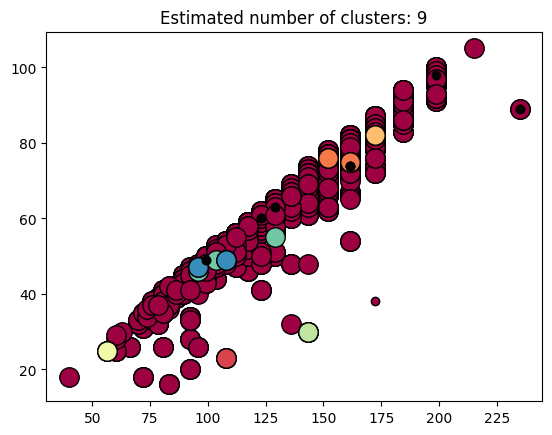

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
# dbscan(X_final,2.7653628172628677,3)
db = DBSCAN(eps=1.577, min_samples=3).fit(X_std)
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

unique_labels = set(labels)
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title(f"Estimated number of clusters: {n_clusters_}")
plt.show()


In [ ]:
!pip install scikit-fuzzy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 994.0/994.0 kB 16.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-fuzzy: filename=scikit_fuzzy-0.4.2-py3-none-any.whl size=894086 sha256=6b0eeafa1b0bd3d42b5926a45c304defb4ceb4ad6b02134964d83e6a1c02db8f
  Stored in directory: /root/.cache/pip/wheels/4f/86/1b/dfd97134a2c8313e519bcebd95d3fedc7be7944db022094bc8
Successfully built scikit-fuzzy


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
import skfuzzy as fuzz

def objective(trail)

# Set the parameters for fuzzy c-means clustering
n_clusters = 4
max_iter = 100
m = 2

# Run fuzzy c-means clustering
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(X_std.T, n_clusters, m, error=0.005, maxiter=max_iter, init=None)

print(cntr,jm, fpc)
# # Plot the results
# fig, ax = plt.subplots()
# ax.set_title('Fuzzy C-Means Clustering')
# ax.scatter(X[:, 0], X[:, 1], c=u.T.argmax(axis=1), s=50, alpha=0.5)
# ax.scatter(cntr[:, 0], cntr[:, 1], marker='*', s=200, linewidths=3, color='k')
# plt.show()

SyntaxError: ignored

In [ ]:
import optuna
import skfuzzy as fuzz

def objective(trial):
  n_clusters = trial.suggest_int('n_cluster',2,10)
  max_iter = trial.suggest_int('max_iter',50,100)
  m = 2

  # Run fuzzy c-means clustering
  cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(X_std.T, n_clusters, m, error=0.005, maxiter=max_iter, init=None)
  print(fpc)
  return 1/fpc

study = optuna.create_study()
study.optimize(objective,n_trials=80)
print("The best parameters = ",study.best_params,'\n')

[I 2023-05-08 08:12:35,249] A new study created in memory with name: no-name-f177ec9d-dffc-4d0a-9410-467a5f05b1b3
[I 2023-05-08 08:12:36,363] Trial 0 finished with value: 5.394335326903011 and parameters: {'n_cluster': 10, 'max_iter': 63}. Best is trial 0 with value: 5.394335326903011.


0.1853796509484179


[I 2023-05-08 08:12:37,045] Trial 1 finished with value: 2.2148945893758545 and parameters: {'n_cluster': 3, 'max_iter': 80}. Best is trial 1 with value: 2.2148945893758545.
[I 2023-05-08 08:12:37,214] Trial 2 finished with value: 1.5857158782991512 and parameters: {'n_cluster': 2, 'max_iter': 99}. Best is trial 2 with value: 1.5857158782991512.


0.45148875472299327
0.630629997268241


[I 2023-05-08 08:12:38,212] Trial 3 finished with value: 4.462172289576632 and parameters: {'n_cluster': 8, 'max_iter': 84}. Best is trial 2 with value: 1.5857158782991512.


0.22410609342358662


[I 2023-05-08 08:12:39,825] Trial 4 finished with value: 5.325825099490176 and parameters: {'n_cluster': 10, 'max_iter': 99}. Best is trial 2 with value: 1.5857158782991512.


0.18776433347308508


[I 2023-05-08 08:12:40,682] Trial 5 finished with value: 3.1192602029642247 and parameters: {'n_cluster': 5, 'max_iter': 75}. Best is trial 2 with value: 1.5857158782991512.


0.32058883675356825


[I 2023-05-08 08:12:41,352] Trial 6 finished with value: 2.2155126838509407 and parameters: {'n_cluster': 3, 'max_iter': 71}. Best is trial 2 with value: 1.5857158782991512.


0.4513627962002134


[I 2023-05-08 08:12:42,359] Trial 7 finished with value: 3.117913435164451 and parameters: {'n_cluster': 5, 'max_iter': 67}. Best is trial 2 with value: 1.5857158782991512.


0.3207273135686835


[I 2023-05-08 08:12:42,649] Trial 8 finished with value: 1.585723515017762 and parameters: {'n_cluster': 2, 'max_iter': 61}. Best is trial 2 with value: 1.5857158782991512.


0.6306269602042187


[I 2023-05-08 08:12:44,129] Trial 9 finished with value: 3.5593377565340703 and parameters: {'n_cluster': 6, 'max_iter': 72}. Best is trial 2 with value: 1.5857158782991512.


0.2809511399035524


[I 2023-05-08 08:12:46,764] Trial 10 finished with value: 4.42662918760014 and parameters: {'n_cluster': 8, 'max_iter': 100}. Best is trial 2 with value: 1.5857158782991512.
[I 2023-05-08 08:12:46,869] Trial 11 finished with value: 1.5857139707148453 and parameters: {'n_cluster': 2, 'max_iter': 57}. Best is trial 11 with value: 1.5857139707148453.


0.22590552712235235
0.6306307559043556


[I 2023-05-08 08:12:46,971] Trial 12 finished with value: 1.5857191378437705 and parameters: {'n_cluster': 2, 'max_iter': 51}. Best is trial 11 with value: 1.5857139707148453.


0.6306287009689372


[I 2023-05-08 08:12:47,319] Trial 13 finished with value: 2.6693703803157094 and parameters: {'n_cluster': 4, 'max_iter': 89}. Best is trial 11 with value: 1.5857139707148453.
[I 2023-05-08 08:12:47,392] Trial 14 finished with value: 1.5857345466975465 and parameters: {'n_cluster': 2, 'max_iter': 52}. Best is trial 11 with value: 1.5857139707148453.


0.3746201753694925
0.6306225730420023


[I 2023-05-08 08:12:47,707] Trial 15 finished with value: 2.6669955303088266 and parameters: {'n_cluster': 4, 'max_iter': 88}. Best is trial 11 with value: 1.5857139707148453.


0.37495375925290897


[I 2023-05-08 08:12:47,932] Trial 16 finished with value: 2.21743893457288 and parameters: {'n_cluster': 3, 'max_iter': 58}. Best is trial 11 with value: 1.5857139707148453.


0.4509707051719188


[I 2023-05-08 08:12:48,481] Trial 17 finished with value: 4.426444919052231 and parameters: {'n_cluster': 8, 'max_iter': 92}. Best is trial 11 with value: 1.5857139707148453.


0.2259149313472346


[I 2023-05-08 08:12:48,779] Trial 18 finished with value: 2.6675930693848318 and parameters: {'n_cluster': 4, 'max_iter': 81}. Best is trial 11 with value: 1.5857139707148453.


0.3748697698598415


[I 2023-05-08 08:12:49,055] Trial 19 finished with value: 3.5834915407477848 and parameters: {'n_cluster': 6, 'max_iter': 56}. Best is trial 11 with value: 1.5857139707148453.


0.27905744680265804


[I 2023-05-08 08:12:49,580] Trial 20 finished with value: 3.9450971473810266 and parameters: {'n_cluster': 7, 'max_iter': 94}. Best is trial 11 with value: 1.5857139707148453.
[I 2023-05-08 08:12:49,652] Trial 21 finished with value: 1.5857303188611456 and parameters: {'n_cluster': 2, 'max_iter': 50}. Best is trial 11 with value: 1.5857139707148453.
[I 2023-05-08 08:12:49,728] Trial 22 finished with value: 1.5857170433186183 and parameters: {'n_cluster': 2, 'max_iter': 55}. Best is trial 11 with value: 1.5857139707148453.


0.25347918255038543
0.6306242543928839
0.630629533947104


[I 2023-05-08 08:12:49,959] Trial 23 finished with value: 2.2165868285715677 and parameters: {'n_cluster': 3, 'max_iter': 66}. Best is trial 11 with value: 1.5857139707148453.
[I 2023-05-08 08:12:50,040] Trial 24 finished with value: 1.5857237625333884 and parameters: {'n_cluster': 2, 'max_iter': 57}. Best is trial 11 with value: 1.5857139707148453.


0.45114406848859095
0.6306268617696548


[I 2023-05-08 08:12:50,250] Trial 25 finished with value: 2.2180002113779125 and parameters: {'n_cluster': 3, 'max_iter': 55}. Best is trial 11 with value: 1.5857139707148453.


0.4508565846252824


[I 2023-05-08 08:12:50,478] Trial 26 finished with value: 2.6738051256412736 and parameters: {'n_cluster': 4, 'max_iter': 61}. Best is trial 11 with value: 1.5857139707148453.
[I 2023-05-08 08:12:50,548] Trial 27 finished with value: 1.585738535243269 and parameters: {'n_cluster': 2, 'max_iter': 66}. Best is trial 11 with value: 1.5857139707148453.


0.37399883424943486
0.630620986861866


[I 2023-05-08 08:12:50,872] Trial 28 finished with value: 3.120322893301784 and parameters: {'n_cluster': 5, 'max_iter': 76}. Best is trial 11 with value: 1.5857139707148453.


0.3204796536110548


[I 2023-05-08 08:12:51,335] Trial 29 finished with value: 5.364044130246597 and parameters: {'n_cluster': 10, 'max_iter': 63}. Best is trial 11 with value: 1.5857139707148453.


0.1864265050246758


[I 2023-05-08 08:12:51,577] Trial 30 finished with value: 2.2157751109307555 and parameters: {'n_cluster': 3, 'max_iter': 70}. Best is trial 11 with value: 1.5857139707148453.
[I 2023-05-08 08:12:51,656] Trial 31 finished with value: 1.5857370263418562 and parameters: {'n_cluster': 2, 'max_iter': 50}. Best is trial 11 with value: 1.5857139707148453.
[I 2023-05-08 08:12:51,730] Trial 32 finished with value: 1.5857241199046779 and parameters: {'n_cluster': 2, 'max_iter': 54}. Best is trial 11 with value: 1.5857139707148453.


0.4513093386900358
0.6306215869266195
0.6306267196466133


[I 2023-05-08 08:12:51,937] Trial 33 finished with value: 2.21208664449481 and parameters: {'n_cluster': 3, 'max_iter': 59}. Best is trial 11 with value: 1.5857139707148453.
[I 2023-05-08 08:12:52,020] Trial 34 finished with value: 1.5857123306652467 and parameters: {'n_cluster': 2, 'max_iter': 54}. Best is trial 34 with value: 1.5857123306652467.


0.4520618586476648
0.6306314081448017


[I 2023-05-08 08:12:52,254] Trial 35 finished with value: 2.216869649612009 and parameters: {'n_cluster': 3, 'max_iter': 63}. Best is trial 34 with value: 1.5857123306652467.


0.45108651299142355


[I 2023-05-08 08:12:52,484] Trial 36 finished with value: 2.6950297880604057 and parameters: {'n_cluster': 4, 'max_iter': 54}. Best is trial 34 with value: 1.5857123306652467.
[I 2023-05-08 08:12:52,572] Trial 37 finished with value: 1.5857286622202682 and parameters: {'n_cluster': 2, 'max_iter': 83}. Best is trial 34 with value: 1.5857123306652467.


0.37105341263025265
0.6306249132180304


[I 2023-05-08 08:12:52,790] Trial 38 finished with value: 2.216558818498865 and parameters: {'n_cluster': 3, 'max_iter': 60}. Best is trial 34 with value: 1.5857123306652467.


0.4511497694779138


[I 2023-05-08 08:12:53,298] Trial 39 finished with value: 4.988875543619884 and parameters: {'n_cluster': 9, 'max_iter': 78}. Best is trial 34 with value: 1.5857123306652467.


0.20044597049105956


[I 2023-05-08 08:12:53,684] Trial 40 finished with value: 3.117233094636586 and parameters: {'n_cluster': 5, 'max_iter': 96}. Best is trial 34 with value: 1.5857123306652467.
[I 2023-05-08 08:12:53,777] Trial 41 finished with value: 1.5857314923442944 and parameters: {'n_cluster': 2, 'max_iter': 52}. Best is trial 34 with value: 1.5857123306652467.
[I 2023-05-08 08:12:53,846] Trial 42 finished with value: 1.585732237066261 and parameters: {'n_cluster': 2, 'max_iter': 52}. Best is trial 34 with value: 1.5857123306652467.


0.3207973127580895
0.6306237877142946
0.6306234915486645


[I 2023-05-08 08:12:54,060] Trial 43 finished with value: 2.2172859262841285 and parameters: {'n_cluster': 3, 'max_iter': 57}. Best is trial 34 with value: 1.5857123306652467.
[I 2023-05-08 08:12:54,147] Trial 44 finished with value: 1.5857146658379861 and parameters: {'n_cluster': 2, 'max_iter': 50}. Best is trial 34 with value: 1.5857123306652467.
[I 2023-05-08 08:12:54,229] Trial 45 finished with value: 1.5857254554587308 and parameters: {'n_cluster': 2, 'max_iter': 54}. Best is trial 34 with value: 1.5857123306652467.


0.4510018253152695
0.6306304794573747
0.6306261885104899


[I 2023-05-08 08:12:54,470] Trial 46 finished with value: 2.2167428802920233 and parameters: {'n_cluster': 3, 'max_iter': 69}. Best is trial 34 with value: 1.5857123306652467.


0.45111230936637303


[I 2023-05-08 08:12:54,698] Trial 47 finished with value: 2.6833469171017708 and parameters: {'n_cluster': 4, 'max_iter': 61}. Best is trial 34 with value: 1.5857123306652467.
[I 2023-05-08 08:12:54,777] Trial 48 finished with value: 1.5857224180205751 and parameters: {'n_cluster': 2, 'max_iter': 64}. Best is trial 34 with value: 1.5857123306652467.
[I 2023-05-08 08:12:54,863] Trial 49 finished with value: 1.5857264737390822 and parameters: {'n_cluster': 2, 'max_iter': 72}. Best is trial 34 with value: 1.5857123306652467.


0.3726689209012452
0.6306273964697299
0.6306257835514585


[I 2023-05-08 08:12:55,168] Trial 50 finished with value: 2.2145161118011516 and parameters: {'n_cluster': 3, 'max_iter': 86}. Best is trial 34 with value: 1.5857123306652467.
[I 2023-05-08 08:12:55,244] Trial 51 finished with value: 1.5857344272992764 and parameters: {'n_cluster': 2, 'max_iter': 50}. Best is trial 34 with value: 1.5857123306652467.
[I 2023-05-08 08:12:55,326] Trial 52 finished with value: 1.5857186068205003 and parameters: {'n_cluster': 2, 'max_iter': 52}. Best is trial 34 with value: 1.5857123306652467.


0.45156591757043546
0.6306226205248866
0.6306289121530109


[I 2023-05-08 08:12:55,526] Trial 53 finished with value: 2.2180289715227475 and parameters: {'n_cluster': 3, 'max_iter': 53}. Best is trial 34 with value: 1.5857123306652467.
[I 2023-05-08 08:12:55,604] Trial 54 finished with value: 1.585719078261975 and parameters: {'n_cluster': 2, 'max_iter': 56}. Best is trial 34 with value: 1.5857123306652467.
[I 2023-05-08 08:12:55,697] Trial 55 finished with value: 1.5857232145574605 and parameters: {'n_cluster': 2, 'max_iter': 58}. Best is trial 34 with value: 1.5857123306652467.


0.4508507385787067
0.6306287246641747
0.6306270796944077


[I 2023-05-08 08:12:55,891] Trial 56 finished with value: 2.2183847005470407 and parameters: {'n_cluster': 3, 'max_iter': 52}. Best is trial 34 with value: 1.5857123306652467.
[I 2023-05-08 08:12:55,972] Trial 57 finished with value: 1.5857181626052308 and parameters: {'n_cluster': 2, 'max_iter': 55}. Best is trial 34 with value: 1.5857123306652467.


0.4507784424195703
0.6306290888142857


[I 2023-05-08 08:12:56,278] Trial 58 finished with value: 4.044448885565485 and parameters: {'n_cluster': 7, 'max_iter': 56}. Best is trial 34 with value: 1.5857123306652467.


0.24725247574990245


[I 2023-05-08 08:12:56,769] Trial 59 finished with value: 2.6672446414841455 and parameters: {'n_cluster': 4, 'max_iter': 74}. Best is trial 34 with value: 1.5857123306652467.


0.37491873990365054


[I 2023-05-08 08:12:57,169] Trial 60 finished with value: 2.21799992381991 and parameters: {'n_cluster': 3, 'max_iter': 55}. Best is trial 34 with value: 1.5857123306652467.


0.45085664307768236


[I 2023-05-08 08:12:57,383] Trial 61 finished with value: 1.5857241012158043 and parameters: {'n_cluster': 2, 'max_iter': 59}. Best is trial 34 with value: 1.5857123306652467.
[I 2023-05-08 08:12:57,549] Trial 62 finished with value: 1.585720857181272 and parameters: {'n_cluster': 2, 'max_iter': 50}. Best is trial 34 with value: 1.5857123306652467.


0.6306267270789927
0.6306280172019487


[I 2023-05-08 08:12:57,698] Trial 63 finished with value: 1.5857183957315868 and parameters: {'n_cluster': 2, 'max_iter': 53}. Best is trial 34 with value: 1.5857123306652467.
[I 2023-05-08 08:12:57,828] Trial 64 finished with value: 1.5857114116277058 and parameters: {'n_cluster': 2, 'max_iter': 54}. Best is trial 64 with value: 1.5857114116277058.


0.6306289961015683
0.6306317736425425


[I 2023-05-08 08:12:58,202] Trial 65 finished with value: 2.2175271575473956 and parameters: {'n_cluster': 3, 'max_iter': 57}. Best is trial 64 with value: 1.5857114116277058.
[I 2023-05-08 08:12:58,381] Trial 66 finished with value: 1.5857281635794187 and parameters: {'n_cluster': 2, 'max_iter': 97}. Best is trial 64 with value: 1.5857114116277058.


0.4509527635756257
0.6306251115214657


[I 2023-05-08 08:12:58,584] Trial 67 finished with value: 1.5857131267242537 and parameters: {'n_cluster': 2, 'max_iter': 55}. Best is trial 64 with value: 1.5857114116277058.


0.6306310915554993


[I 2023-05-08 08:12:59,244] Trial 68 finished with value: 3.949841724481843 and parameters: {'n_cluster': 7, 'max_iter': 61}. Best is trial 64 with value: 1.5857114116277058.


0.2531747016093877


[I 2023-05-08 08:12:59,905] Trial 69 finished with value: 2.220990240829783 and parameters: {'n_cluster': 3, 'max_iter': 89}. Best is trial 64 with value: 1.5857114116277058.
[I 2023-05-08 08:13:00,066] Trial 70 finished with value: 1.5857235282062334 and parameters: {'n_cluster': 2, 'max_iter': 59}. Best is trial 64 with value: 1.5857114116277058.


0.4502496146162221
0.6306269549592908


[I 2023-05-08 08:13:00,264] Trial 71 finished with value: 1.5857213608592375 and parameters: {'n_cluster': 2, 'max_iter': 55}. Best is trial 64 with value: 1.5857114116277058.
[I 2023-05-08 08:13:00,436] Trial 72 finished with value: 1.585714324239139 and parameters: {'n_cluster': 2, 'max_iter': 54}. Best is trial 64 with value: 1.5857114116277058.


0.6306278168934679
0.6306306153094898


[I 2023-05-08 08:13:00,875] Trial 73 finished with value: 2.2178017359215385 and parameters: {'n_cluster': 3, 'max_iter': 51}. Best is trial 64 with value: 1.5857114116277058.
[I 2023-05-08 08:13:01,066] Trial 74 finished with value: 1.5857247610767773 and parameters: {'n_cluster': 2, 'max_iter': 53}. Best is trial 64 with value: 1.5857114116277058.


0.4508969326712521
0.6306264646589461


[I 2023-05-08 08:13:01,248] Trial 75 finished with value: 1.5857292109289147 and parameters: {'n_cluster': 2, 'max_iter': 58}. Best is trial 64 with value: 1.5857114116277058.


0.6306246950033817


[I 2023-05-08 08:13:01,635] Trial 76 finished with value: 2.2180127879511944 and parameters: {'n_cluster': 3, 'max_iter': 51}. Best is trial 64 with value: 1.5857114116277058.
[I 2023-05-08 08:13:01,763] Trial 77 finished with value: 1.5857223809181937 and parameters: {'n_cluster': 2, 'max_iter': 65}. Best is trial 64 with value: 1.5857114116277058.


0.4508540281788511
0.6306274112250102


[I 2023-05-08 08:13:02,593] Trial 78 finished with value: 4.905355473474923 and parameters: {'n_cluster': 9, 'max_iter': 93}. Best is trial 64 with value: 1.5857114116277058.
[I 2023-05-08 08:13:02,677] Trial 79 finished with value: 1.585727729240943 and parameters: {'n_cluster': 2, 'max_iter': 62}. Best is trial 64 with value: 1.5857114116277058.


0.20385882438232478
0.6306252842527263
The best parameters =  {'n_cluster': 2, 'max_iter': 54} 



##Labeled Data

In [ ]:
color_dict =[{0:'rock',1:'reggae',2:'metal',3:'pop',4:'classical',5:'hiphop',6:'jazz',7:'country',8:'blues',9:'disco'}]

In [ ]:
final_df = pd.DataFrame(columns=["Comp1", "Comp2","Label"])

for i in range(len(music_proj)):
    
    dicti = dict()
    
    dicti["Comp1"] = music_proj[i, 0]
    dicti["Comp2"] = music_proj[i, 1]
    #dicti["Comp3"] = music_proj[i, 2]

    # key = y[i]
    dicti["Label"] = y[i]    
    final_df = final_df.append(dicti, ignore_index = True)
final_df

Streaming output truncated to the last 5000 lines.
<ipython-input-15-40b470573ba7>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_df = final_df.append(dicti, ignore_index = True)
<ipython-input-15-40b470573ba7>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_df = final_df.append(dicti, ignore_index = True)
<ipython-input-15-40b470573ba7>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_df = final_df.append(dicti, ignore_index = True)
<ipython-input-15-40b470573ba7>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_df = final_df.append(dicti, ignore_index = True)
<ipython-input-15-40b470573ba7>:13: FutureWar

,Comp1,Comp2,Label
0,-1.902928,-1.077136,malayalam
1,-13.705815,-50.465935,malayalam
2,32.052292,14.014630,malayalam
3,-3.933823,33.186768,malayalam
4,5.305110,17.506710,malayalam
...,...,...,...
5007,-24.314449,21.418165,marathi
5008,21.188684,-0.220575,marathi
5009,3.355000,26.308781,marathi
5010,22.904594,-28.251860,marathi


In [ ]:
bengali   gujrati  kannada    marathi  punjabi
bhojpuri  hindi    malayalam  odia     tamil

In [ ]:
import plotly.graph_objects as go
import plotly.express as px


for_x = final_df.Comp1.tolist()
for_y = final_df.Comp2.tolist()
for_label = final_df.Label.tolist()
for_hover = final_df.Label.tolist()

fig = px.scatter(x=for_x, y=for_y, color=for_label,
                 title="T-SNE",
                 color_discrete_map={"bengali":"blue","gujrati":"green","kannada":"red","marathi":"cyan","punjabi":"gray","bhojpuri":"yellow","hindi":"black","malayalam":"white","odia":"orange","tamil":"pink"}, width=1500, height=1000)

fig.update_layout(
    xaxis=dict(title = 'Comp-1', showgrid=True, ticks='inside', zeroline=True, mirror=True, showline=True, linecolor='white'),
    yaxis=dict(title = 'Comp-2', showgrid=True, ticks='inside', zeroline=True, mirror=True, showline=True, linecolor='white'),
    plot_bgcolor='#555555',
    font=dict(
        family="Times New Roman",
        size=16,
        color="Black"))
fig.update_traces(marker=dict(size=8,))

fig.show(renderer = "colab")

In [ ]:
import plotly.graph_objects as go
import plotly.express as px


for_x = pca_df.zcr.tolist()
for_y = pca_df.ae.tolist()
for_label = pca_df.name.tolist()
for_hover = pca_df.name.tolist()

fig = px.scatter(x=for_x, y=for_y, color=for_label,
                 title="PCA",
                 color_discrete_map={"bengali":"blue","gujrati":"green","kannada":"red","marathi":"cyan","punjabi":"gray","bhojpuri":"yellow","hindi":"black","malayalam":"white","odia":"orange","tamil":"pink"}, width=1500, height=1000)

fig.update_layout(
    xaxis=dict(title = 'Comp-1', showgrid=True, ticks='inside', zeroline=True, mirror=True, showline=True, linecolor='white'),
    yaxis=dict(title = 'Comp-2', showgrid=True, ticks='inside', zeroline=True, mirror=True, showline=True, linecolor='white'),
    plot_bgcolor='#555555',
    font=dict(
        family="Times New Roman",
        size=16,
        color="Black"))
fig.update_traces(marker=dict(size=8,))

fig.show(renderer = "colab")

## Chi-Sqaure Test

In [ ]:
colums = ['tempo', 'beats', 'ae', 'rms', 'zcr', 'spec_cent', 'bw', 'spec_roll', 'mfcc']

# Perform the Chi-square test
# chi2, p_value = stats.chisquare(df_data[colums].value_counts().unstack().T)

# Print the Chi-square statistic and p-value
print("Chi-square statistic:", chi2)
print("P-value:", p_value)

NameError: ignored

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency


import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

for val in colums:

  contigency= pd.crosstab(df_data['name'], df_data[val]) 
  contigency



  # Chi-square test of independence. 
  c, p, dof, expected = chi2_contingency(contigency) 
  # Print the p-value
  print("For",val,"the p-value is=",p)


  

For tempo the p-value is= 5.176612769804859e-63
For beats the p-value is= 3.273639579592379e-30
For ae the p-value is= 0.35017768056023213
For rms the p-value is= 0.3491886703051036
For zcr the p-value is= 0.3953953555571264
For spec_cent the p-value is= 0.3480570510968695
For bw the p-value is= 0.3480570510968614
For spec_roll the p-value is= 0.35110188139159093
For mfcc the p-value is= 0.3480570510968695
